## Analysis of Adult Data Anthropometric Data
Source: https://www.scribd.com/doc/124837000/Adult-Data-Handbook?doc_id=124837000&download=true&order=661425273

In [17]:
from tools_new import calc_joint_positions_editted, plot_skeleton, calculate_distances, calc_constrained_angles, calc_joint_positions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy.stats import norm
from PIL import Image

### Reading Adult Data Dataset

In [18]:
df = pd.read_csv(r'raw_data/adultdata_data.csv')
df.head()

df

,Dimension,Man5,Man50,Man95,Woman5,Woman50,Woman95
0,(59)ShoulderHeight,557.9,609.5,661.1,523.0,572.7,622.4
1,(61)Mid-ShoulderHeight,585.7,634.7,683.8,533.3,580.2,627.1
2,(83)SacralHeight,136.3,161.6,187.0,133.8,158.9,184.1
3,(112)ShoulderToElbow,346.6,376.7,406.7,312.5,341.5,370.6
4,(124)ElbowToTipOfMiddleFinger,442.0,477.0,512.1,396.3,431.1,465.9
5,(125)ElbowToGrip,332.7,365.5,398.4,291.4,325.5,359.7
6,(215)ButtockToKnee,552.2,612.6,673.0,521.4,588.9,656.4
7,(230)TopOfKneeHeight,497.8,544.4,591.1,450.3,493.9,537.4
8,(232)KneeCreaseToAnkle,377.1,417.2,457.3,336.8,373.5,410.1
9,(242)FootLength,245.3,266.8,288.2,220.2,241.1,262.1


In [19]:
df = df.set_index('Dimension').transpose()

data = pd.DataFrame()
data['FootLength'] = df['(242)FootLength'] - df['(254)RearHeelToOuterAnkle']
data['LowerLegLength'] = df['(232)KneeCreaseToAnkle']
data['ThighLength'] = df['(215)ButtockToKnee'] - df['(83)SacralHeight']
data['TorsoHeight'] = df['(59)ShoulderHeight'] - df['(83)SacralHeight']
data['UpperArmLength'] = df['(112)ShoulderToElbow']
data['ForearmLength'] = df['(125)ElbowToGrip']

data

,FootLength,LowerLegLength,ThighLength,TorsoHeight,UpperArmLength,ForearmLength
Man5,198.0,377.1,415.9,421.6,346.6,332.7
Man50,211.3,417.2,451.0,447.9,376.7,365.5
Man95,224.5,457.3,486.0,474.1,406.7,398.4
Woman5,177.6,336.8,387.6,389.2,312.5,291.4
Woman50,190.8,373.5,430.0,413.8,341.5,325.5
Woman95,204.1,410.1,472.3,438.3,370.6,359.7


### Visualising 2D Human Skeleton + Calculating Dimensions A, B, C & D

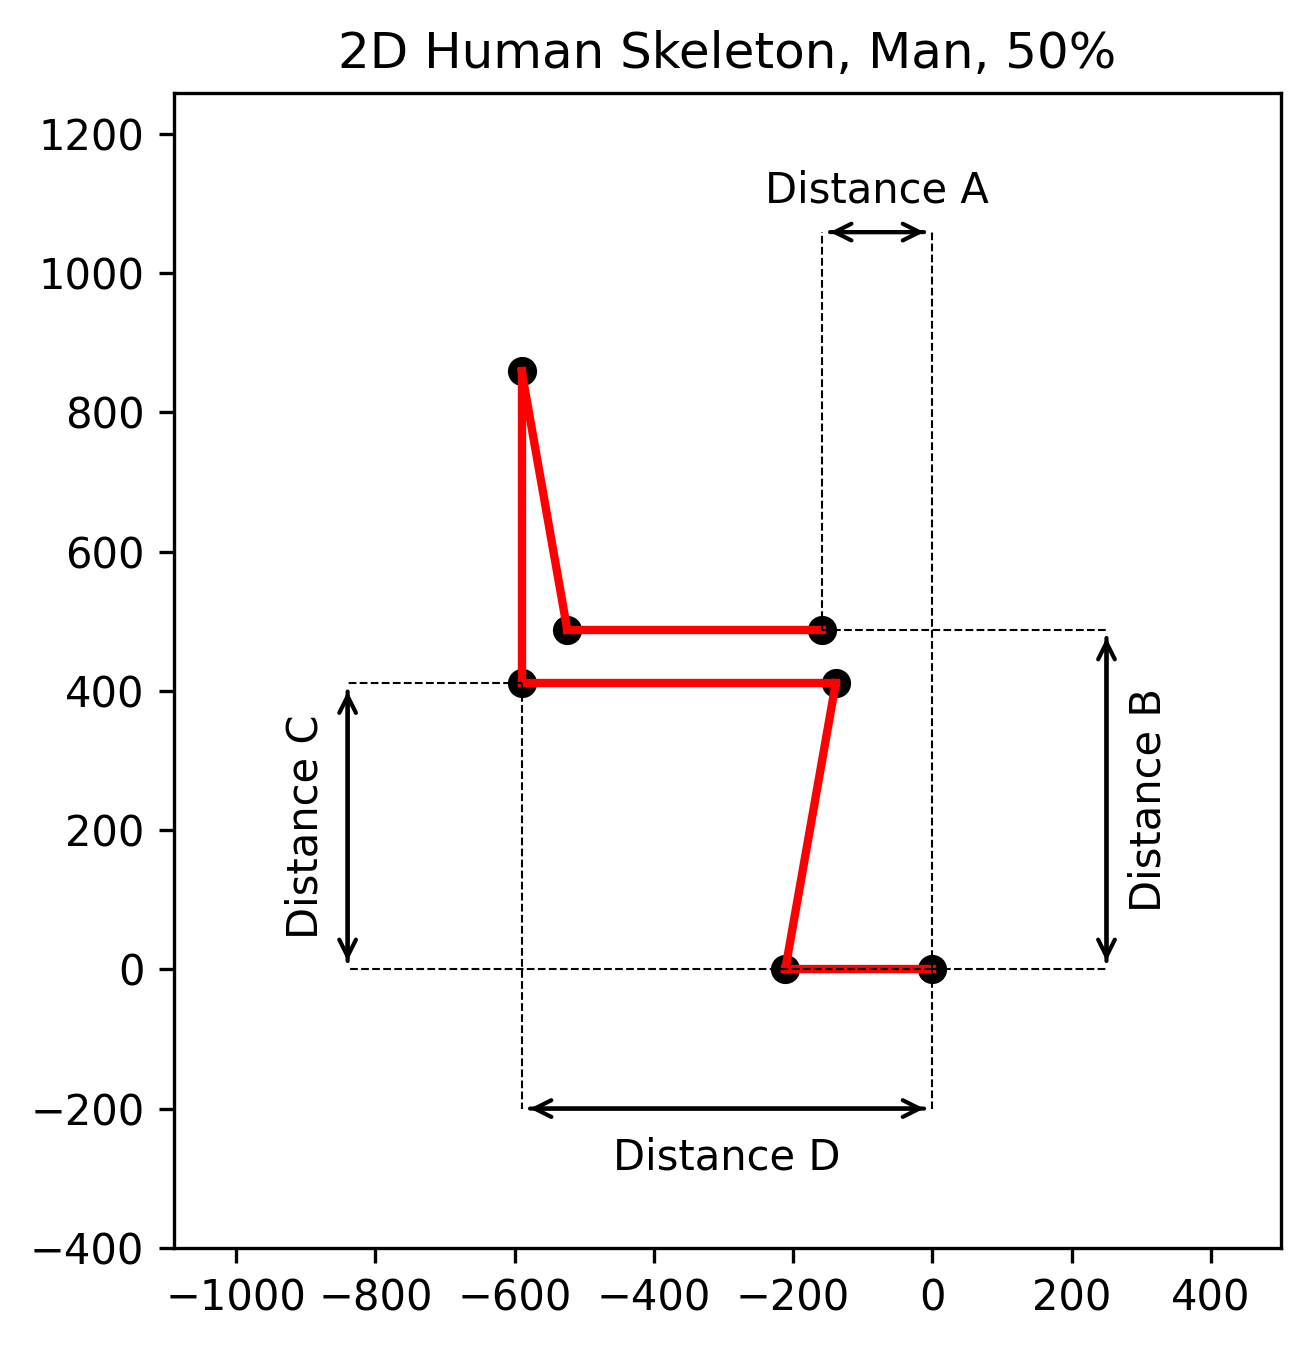

A (Horizontal distance):  158.94 mm
B (Vertical distance):  487.78 mm
C (Vertical distance):  410.86 mm
D (Horizontal distance):  589.85 mm


In [20]:
# Input gender, percentile and back inclination angle
gender = 'Man'
percentile = '50'
back_inclination = 90           # Angle of back relative to x-axis (FIXED)

# Input arbitrary joint angles
ankle_angle = 80                # Ankle Flexion
knee_angle = 80                 # Knee Flexion
shoulder_angle = 10             # Shoulder Flexion 
angles_in = [ankle_angle, knee_angle, back_inclination, shoulder_angle]

# Calculate and plot joints
joints = calc_joint_positions(data, gender, percentile, angles_in)
plot_skeleton(joints, dists = True, gender=gender, percentile=percentile, overlay=False)

# Calculate the required distances
distance_A, distance_B, distance_C, distance_D = calculate_distances(joints)

# Output the distances
print(f"A (Horizontal distance): {distance_A: .2f} mm")
print(f"B (Vertical distance): {distance_B: .2f} mm")
print(f"C (Vertical distance): {distance_C: .2f} mm")
print(f"D (Horizontal distance): {distance_D: .2f} mm")

### Calculating Max / Min for Dimensions A, B, C & D:

In [21]:
### PARAMETERS ###

# Input gender, percentile and back inclination angle
gender = 'Man'
percentile = '50'
back_inclination = 90

# Chosen max / min
min_or_max = 'max'

# Define the ranges for angles a, b, and d
ankle_range = np.arange(80,101,1)  
knee_range = np.arange(80,101,1)
shoulder_range = np.arange(0,46,1) 

hip_range = (80, 100)      # Valid range for c
elbow_range = (80, 120)   # Valid range for e

In [22]:
A = np.full((len(ankle_range), len(knee_range), len(shoulder_range)), np.nan, dtype=float)
B = np.full_like(A, np.nan)
C = np.full_like(A, np.nan)
D = np.full_like(A, np.nan)
angle_list = np.full((len(ankle_range), len(knee_range), len(shoulder_range)), np.nan, dtype=object)

for i, a in enumerate(ankle_range):  # ankle
    for j, b in enumerate(knee_range):  # knee
        for k, d in enumerate(shoulder_range):  # shoulder
            # Try to solve for constrained angles
            
            angles_in = calc_constrained_angles(a, b, d, hip_range, elbow_range, back_inclination)

            if angles_in is None:
                # Invalid combo — fill with NaNs
                A[i, j, k] = np.nan
                B[i, j, k] = np.nan
                C[i, j, k] = np.nan
                D[i, j, k] = np.nan
                angle_list[i, j, k] = np.nan
            
            else:
                joints = calc_joint_positions_editted(data, gender, percentile, angles_in)
                
                if joints[6][1] < joints[2][1]+100:
                    # Invalid combo — fill with NaNs
                    A[i, j, k] = np.nan
                    B[i, j, k] = np.nan
                    C[i, j, k] = np.nan
                    D[i, j, k] = np.nan
                    angle_list[i, j, k] = np.nan
                else:
                    distance_A, distance_B, distance_C, distance_D = calculate_distances(joints)
                
                    # Store results
                    A[i, j, k] = distance_A
                    B[i, j, k] = distance_B
                    C[i, j, k] = distance_C
                    D[i, j, k] = distance_D
                    angle_list[i, j, k] = angles_in
                
valid_count = np.sum(~np.isnan(A))
print(f"Valid combinations: {valid_count} / {A.size}")

Valid combinations: 5882 / 20286


In [23]:
# MINIMUM A:
min_A_index = np.unravel_index(np.nanargmin(A), A.shape)
min_A_value = np.nanmin(A)
angles_min_A = angle_list[min_A_index]

# MAXIMUM B:
max_A_index = np.unravel_index(np.nanargmax(A), A.shape)
max_A_value = np.nanmax(A)
angles_max_A = angle_list[max_A_index]

# MINIMUM B:
min_B_index = np.unravel_index(np.nanargmin(B), B.shape)
min_B_value = np.nanmin(B)
angles_min_B = angle_list[min_B_index]

# MAXIMUM B:
max_B_index = np.unravel_index(np.nanargmax(B), B.shape)
max_B_value = np.nanmax(B)
angles_max_B = angle_list[max_B_index]

# MINIMUM C:
min_C_index = np.unravel_index(np.nanargmin(C), C.shape)
min_C_value = np.nanmin(C)
angles_min_C = angle_list[min_C_index]

# MAXIMUM C:
max_C_index = np.unravel_index(np.nanargmax(C), C.shape)
max_C_value = np.nanmax(C)
angles_max_C = angle_list[max_C_index]

# MINIMUM D:
min_D_index = np.unravel_index(np.nanargmin(D), D.shape)
min_D_value = np.nanmin(D)
angles_min_D = angle_list[min_D_index]

# MAXIMUM D:
max_D_index = np.unravel_index(np.nanargmax(D), D.shape)
max_D_value = np.nanmax(D)
angles_max_D = angle_list[max_D_index]

Maximum A value: 281.61254171580777


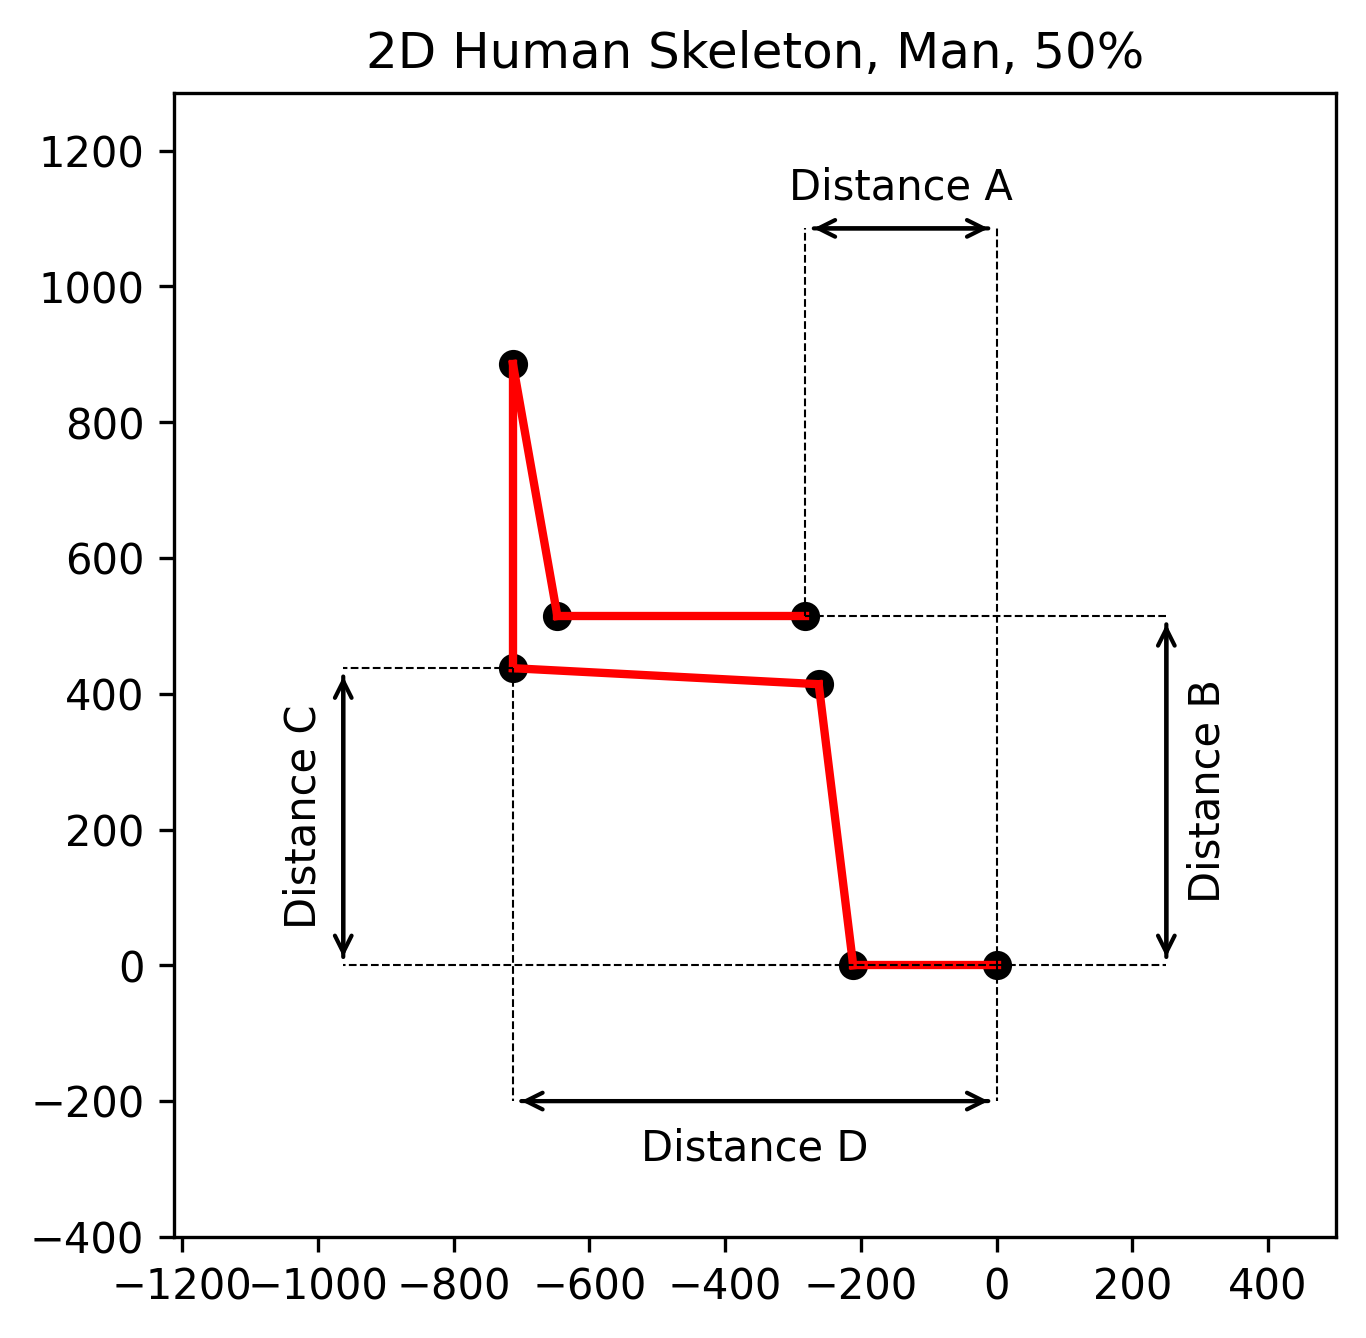

Maximum B value: 654.8463864048665


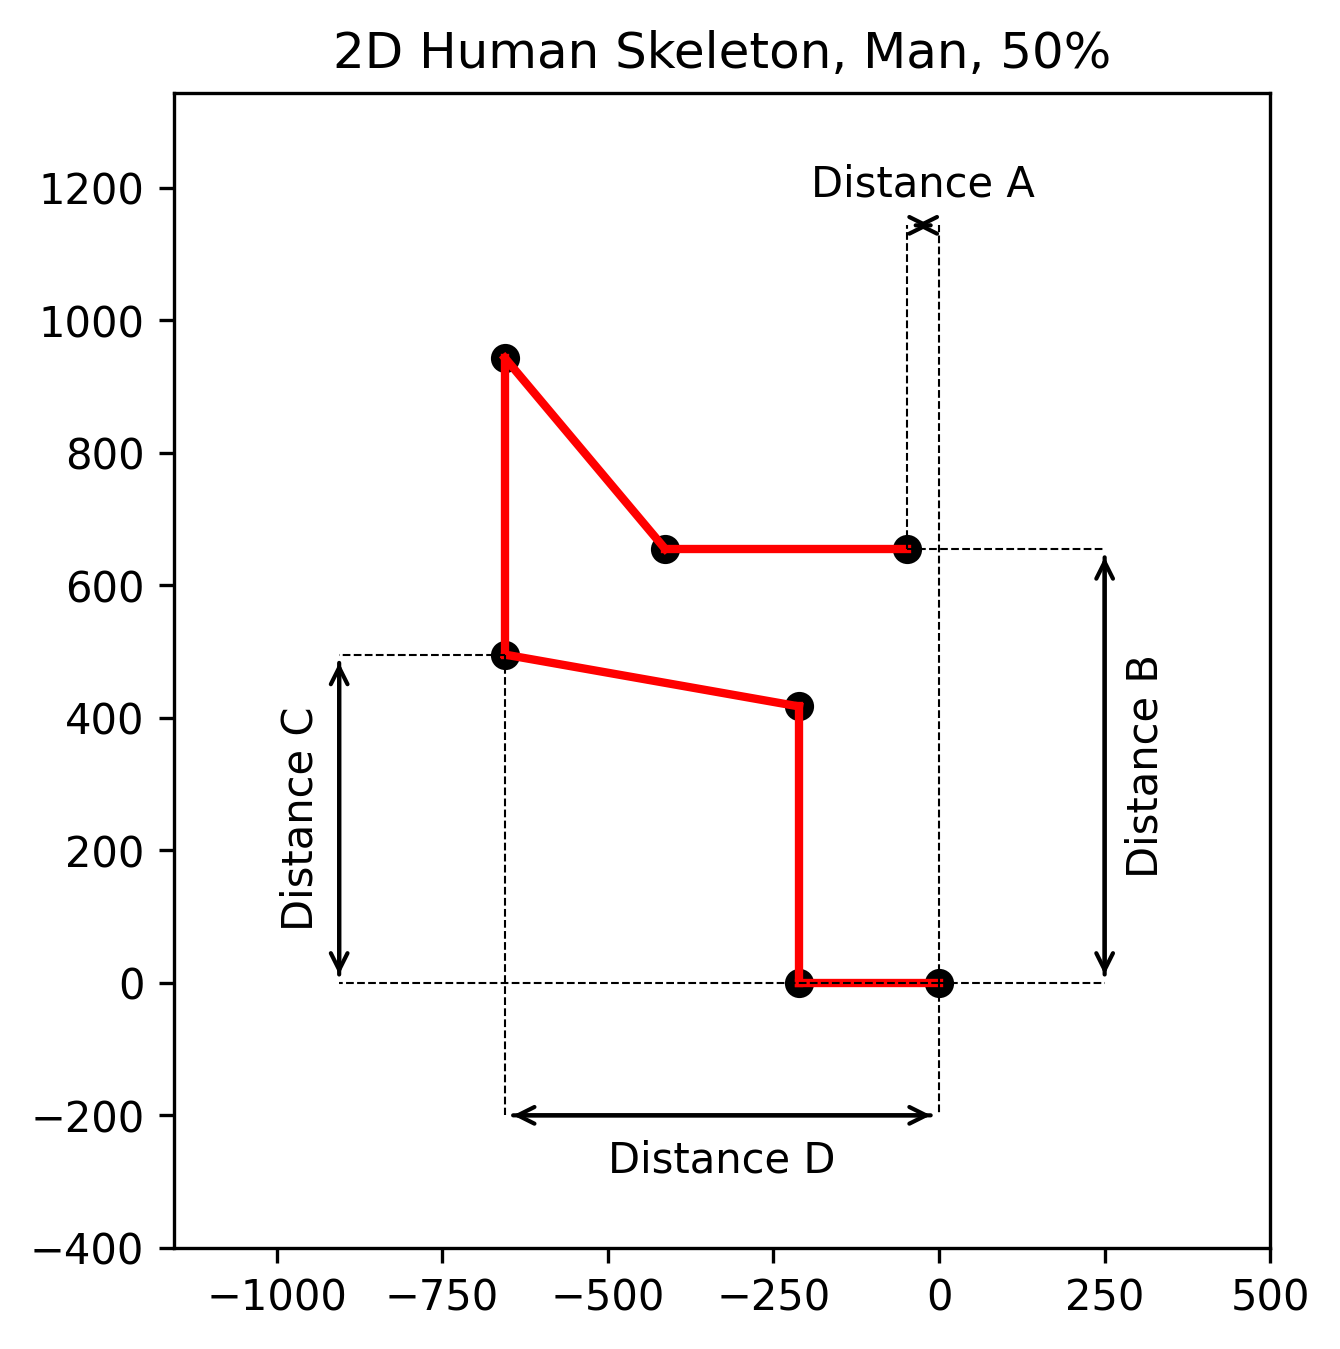

Maximum C value: 495.51532812778555


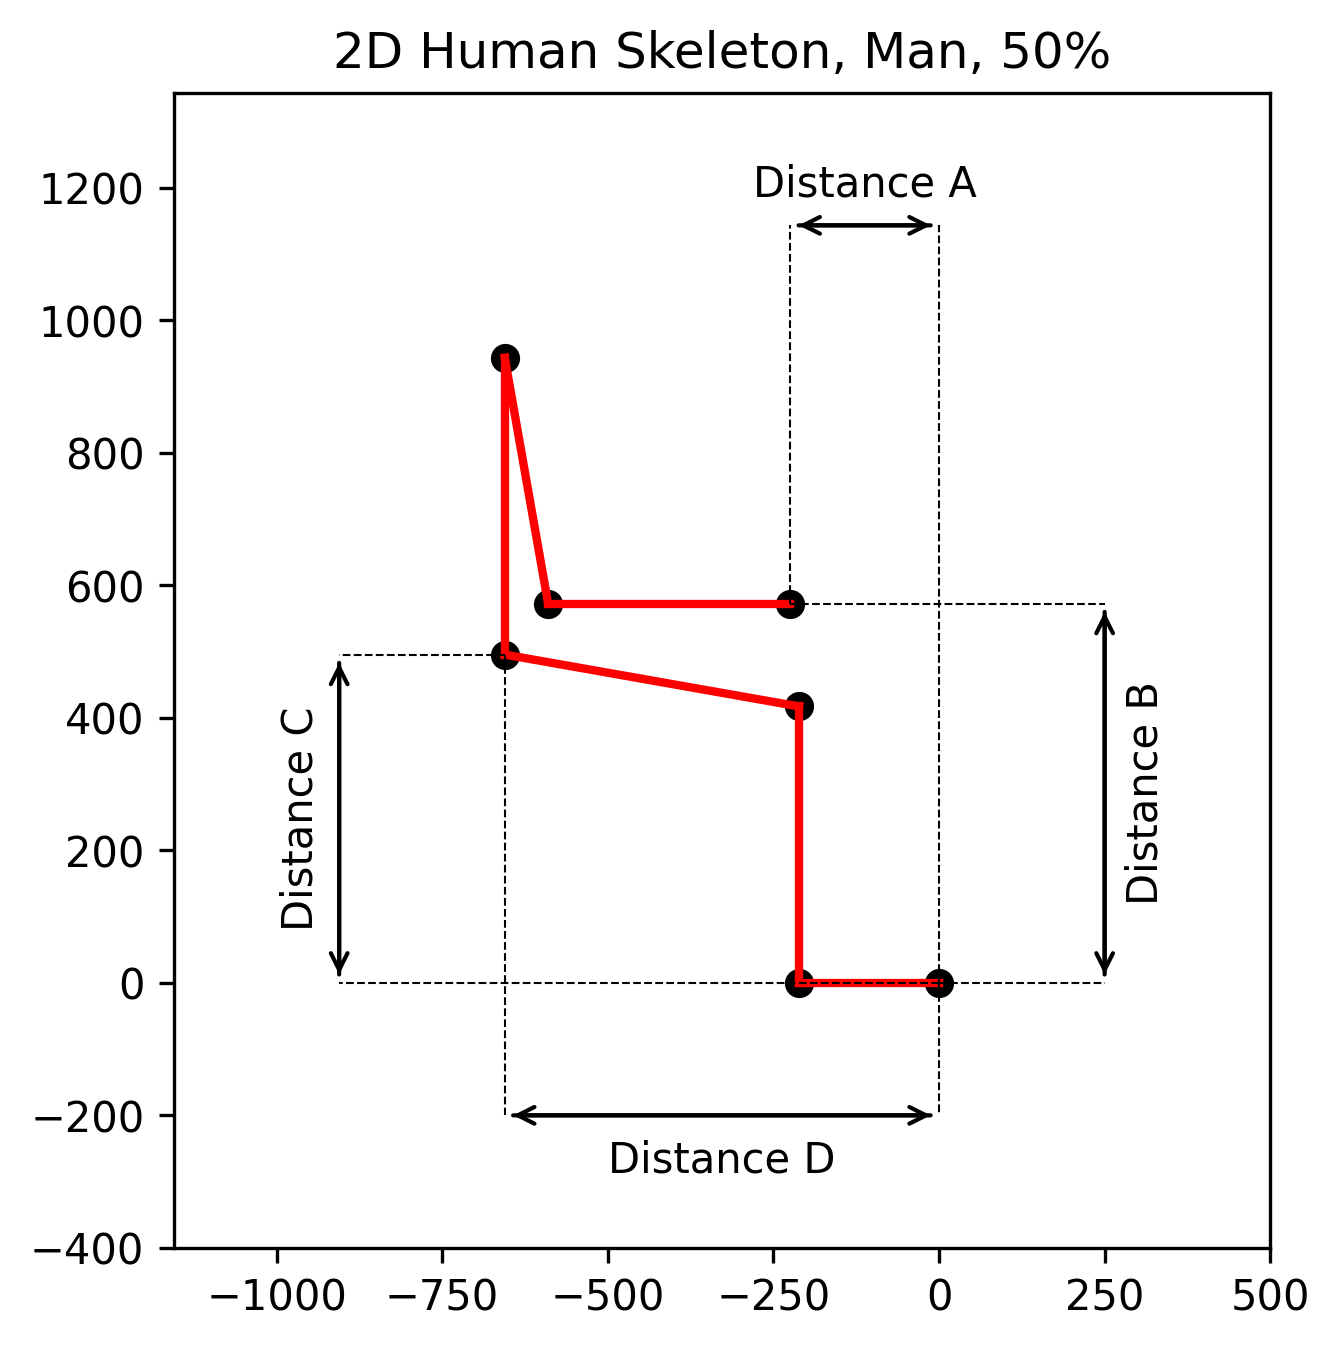

Maximum D value: 734.7460197226433


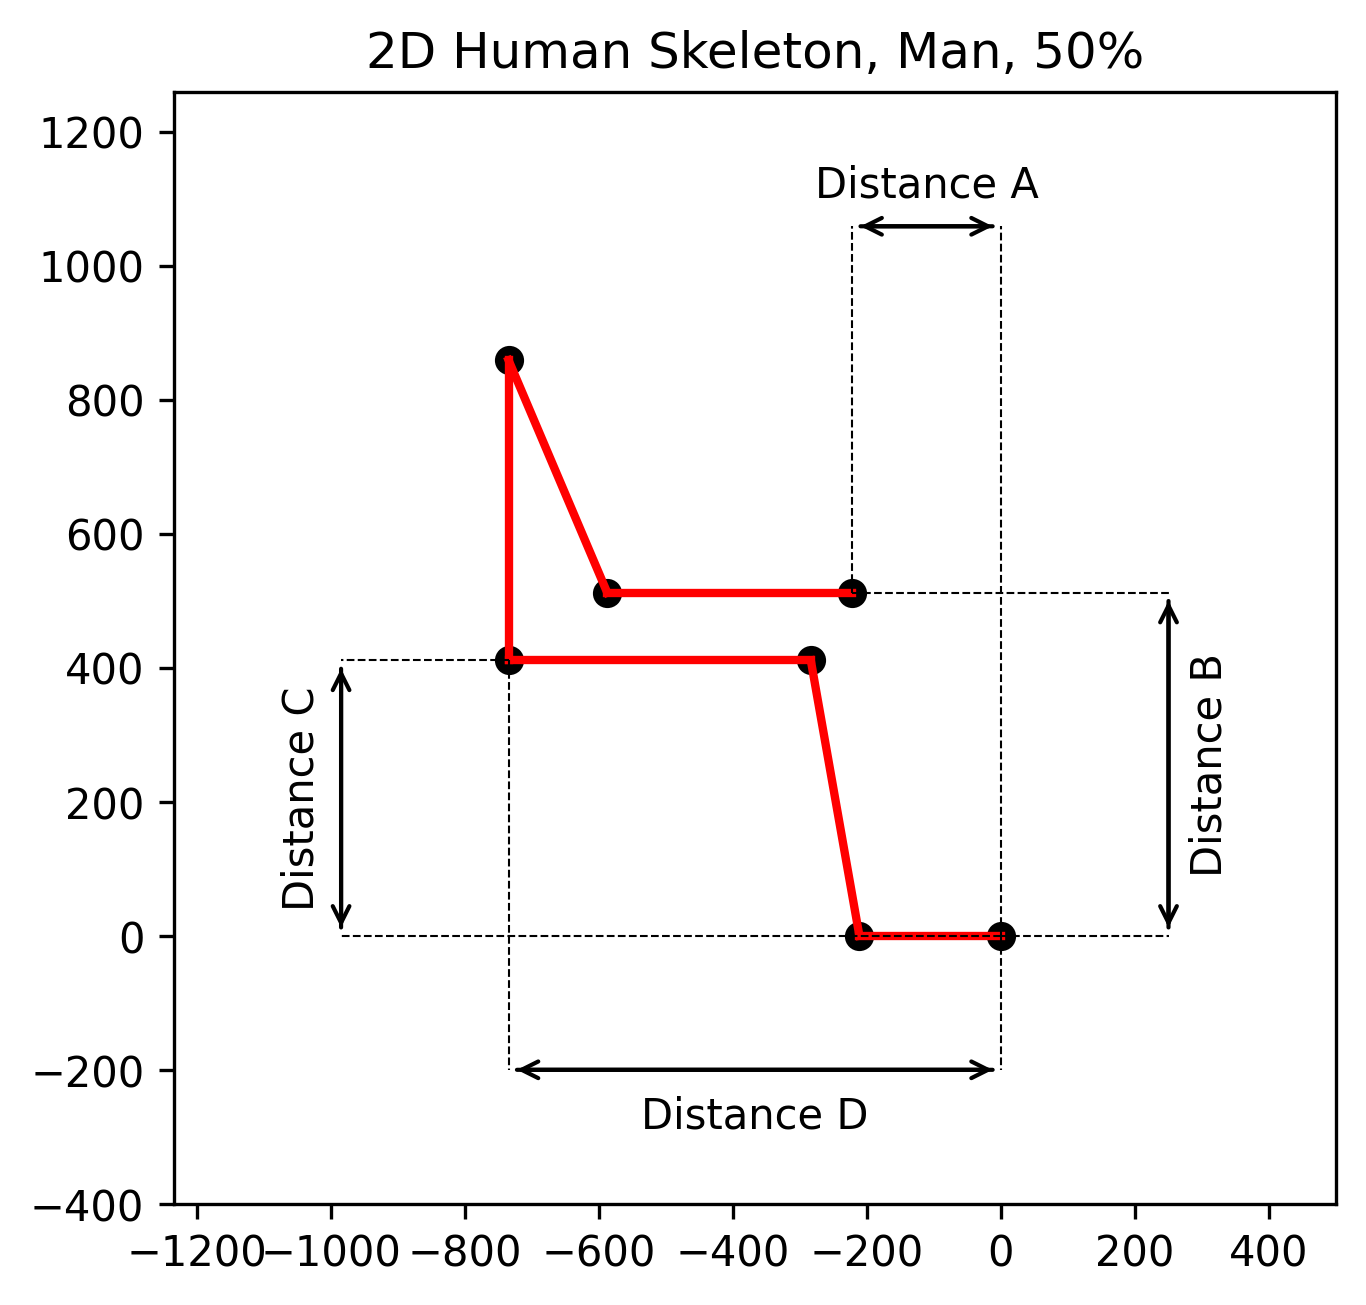

In [24]:
dimensions = ['A','B','C','D']

for dimension in dimensions:
    value = globals()[f"{min_or_max}_{dimension}_value"]
    index = globals()[f"{min_or_max}_{dimension}_index"]
    angles = globals()[f"angles_{min_or_max}_{dimension}"]

    # Print the minimum value dynamically
    if min_or_max == 'min':
        Minimum_or_Maximum = 'Minimum'
        print(f"{Minimum_or_Maximum} {dimension} value: {value}")
        # print(f"Index: {index}")
        # print(f"Angles: {angles}")

    else:
        Minimum_or_Maximum = 'Maximum'
        print(f"{Minimum_or_Maximum} {dimension} value: {value}")

    joints = calc_joint_positions_editted(data, gender, percentile, angles)
    plot_skeleton(joints, dists = True, gender=gender, percentile=percentile, overlay=False)